Import libraries

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

Load datasets

In [12]:
df_train = pd.read_csv('../data/train.csv')
df_test = pd.read_csv('../data/test.csv')

Separate the labels from the features and remove columns we dont need

In [13]:
# separate labels from features
training_label_cols = ['TotalTimeStopped_p20','TotalTimeStopped_p40','TotalTimeStopped_p50',
                       'TotalTimeStopped_p60','TotalTimeStopped_p80',
                       'TimeFromFirstStop_p20','TimeFromFirstStop_p40','TimeFromFirstStop_p50',
                       'TimeFromFirstStop_p60','TimeFromFirstStop_p80',
                       'DistanceToFirstStop_p20','DistanceToFirstStop_p40','DistanceToFirstStop_p50',
                       'DistanceToFirstStop_p60','DistanceToFirstStop_p80']

df_train_y = df_train[training_label_cols]

# drop columns not needed
df_test_X = df_test.drop(columns=['RowId'])
df_train_X = df_train.drop(columns=['RowId']+training_label_cols)

Separate the Data by City

In [14]:
cities = ['Atlanta','Philadelphia','Boston','Chicago']
city_training_datasets_X = {}
city_training_datasets_y = {}
city_testing_datasets_X = {}

# training
for city in cities:
    # get rows for this city
    city_idxs = (df_train_X['City'] == city).values.nonzero()[0]

    # get X (data) and y (labels)
    city_training_datasets_X[city] = df_train_X.loc[city_idxs]
    city_training_datasets_y[city] = df_train_y.loc[city_idxs]

    # drop the city column from X (data)
    city_training_datasets_X[city] = city_training_datasets_X[city].drop(columns=['City'])

# testing
for city in cities:
    # get rows for this city
    city_idxs = (df_test_X['City'] == city).values.nonzero()[0]

    # get X (data)
    city_testing_datasets_X[city] = df_test_X.loc[city_idxs]

    # drop the city column from X (data)
    city_testing_datasets_X[city] = city_testing_datasets_X[city].drop(columns=['City'])

Feature Exploration
* Try to see if grouping cars by different characteristics shows any relationship with the the target values

**Go Straight**
* if the entry and exit street are the same (or the headings are the same), then we treat this as a car NOT making a turn. Intuitively cars that make turns may wait longer or take longer to go through the intersection than cars that go straight.

**Type of Turn**
* we can check left,right, and U turns using the entry and exit headings
* in general we have 8 headings: N,NE,E,SE,S,SW,W,NW which we can encode using 0-7
    * for each heading, a left turn would be the three numbers below, a right turn would be the three numbers above, and a U turn would be the number plus four

In [189]:
target_cols = ['TotalTimeStopped_p20','TotalTimeStopped_p50','TotalTimeStopped_p80',
                'DistanceToFirstStop_p20','DistanceToFirstStop_p50','DistanceToFirstStop_p80']

# categorize turns
encoding = [0,1,2,3,4,5,6,7]
direction = ["N","NE","E","SE","S","SW","W","NW"]
left_turn = []
right_turn = []
u_turn = []
for e,d in zip(encoding,direction):
    for i in range(1,4):
        left_turn.append((d+'-'+direction[e-i]))
    for i in range(1,4):
        right_turn.append((d+'-'+direction[(e+i)%8]))
    u_turn.append((d+'-'+direction[(e+4)%8]))

# Check if a car went straight or not
# if it did not go straight, characterize the turn as right, left, or U-turn (0000, 0100, 0010, 0001)
turn_type_X = {}
straight_X_r2s = {city: {col: 0 for col in target_cols} for city in cities}
for city in cities:
    turn_type_X[city] = np.zeros((len(city_training_datasets_X[city]),4))

    # get entry/exit street names and headings
    entry_name = city_training_datasets_X[city]['EntryStreetName']
    exit_name = city_training_datasets_X[city]['ExitStreetName']
    entry_heading = city_training_datasets_X[city]['EntryHeading']
    exit_heading = city_training_datasets_X[city]['ExitHeading']

    # same street/heading --> straight (no turn)
    same_street_idxs = (entry_name==exit_name).values
    same_heading_idxs = (entry_heading==exit_heading).values
    straight_idxs = np.logical_or(same_street_idxs,same_heading_idxs)
    turn_type_X[city][straight_idxs][:] = 0

    # encode turn
    turn_enc = np.array([f'{x}-{y}' for x, y in zip(entry_heading, exit_heading)])

    # left turn
    left_idxs = np.zeros(len(entry_heading),dtype=int)
    for lt in left_turn:
        left_idxs[(turn_enc==lt).nonzero()[0]] = 1
    turn_type_X[city][left_idxs.nonzero()[0]] = np.array([0,1,0,0])

    # right turn
    right_idxs = np.zeros(len(entry_heading),dtype=int)
    for rt in right_turn:
        right_idxs[(turn_enc==rt).nonzero()[0]] = 1
    turn_type_X[city][right_idxs.nonzero()[0]] = np.array([0,0,1,0])

    # U-turn
    u_idxs = np.zeros(len(entry_heading),dtype=int)
    for ut in u_turn:
        u_idxs[(turn_enc==ut).nonzero()[0]] = 1
    turn_type_X[city][u_idxs.nonzero()[0]] = np.array([0,0,0,1])

    for target_col in target_cols:
        target = city_training_datasets_y[city][target_col].values
        model = LinearRegression()
        model.fit(turn_type_X[city],target)
        r2 = r2_score(target,model.predict(turn_type_X[city]))
        straight_X_r2s[city][target_col] = r2   

    # display distribution of turns per city
    print(f"City: {city}, no turn   : {np.all(turn_type_X[city] == np.array([0,0,0,0]),axis=1).mean()}")
    print(f"City: {city}, right turns: {np.all(turn_type_X[city] == np.array([0,1,0,0]),axis=1).mean()}")
    print(f"City: {city}, left turns:  {np.all(turn_type_X[city] == np.array([0,0,1,0]),axis=1).mean()}")
    print(f"City: {city}, u turns:     {np.all(turn_type_X[city] == np.array([0,0,0,1]),axis=1).mean()}")
    print()

City: Atlanta, no turn   : 0.5744996293550778
City: Atlanta, right turns: 0.21775389177168272
City: Atlanta, left turns:  0.20723524449784003
City: Atlanta, u turns:     0.0005112343753994018

City: Philadelphia, no turn   : 0.698936799944649
City: Philadelphia, right turns: 0.1484508132237589
City: Philadelphia, left turns:  0.15218444176231366
City: Philadelphia, u turns:     0.00042794506927841286

City: Boston, no turn   : 0.6469037101731638
City: Boston, right turns: 0.1821551140149034
City: Boston, left turns:  0.16881371873897782
City: Boston, u turns:     0.002127457072954982

City: Chicago, no turn   : 0.9117353051148807
City: Chicago, right turns: 0.047012949354821476
City: Chicago, left turns:  0.04112965379361918
City: Chicago, u turns:     0.0001220917366786469



Plot the r2 scores of the turning feature per city and per target variable
* Atlanta intersection wait times seem to have at least some connection to the turn type which aligns with the distribution of turns above. For example, almost all intersections in chicago were straight paths (no turns) so turning does not explain the wait time

(0.0, 1.0)

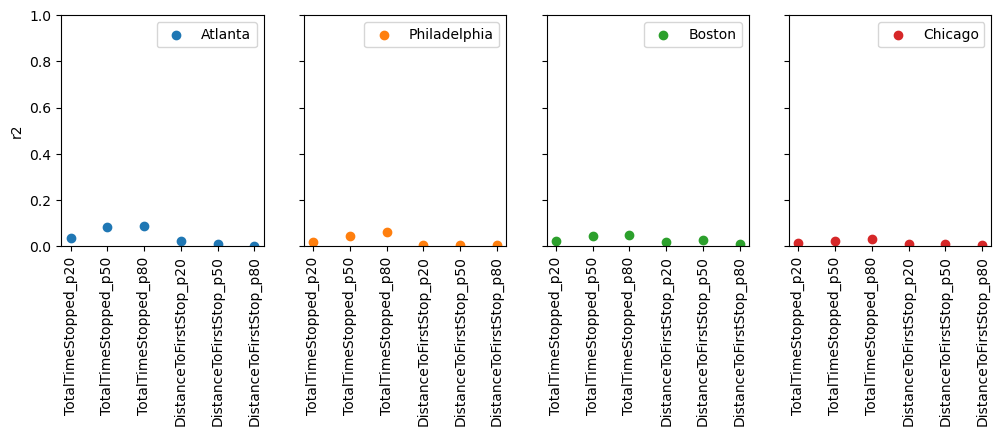

In [192]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
fig,ax = plt.subplots(1,len(cities),figsize=(12,3),sharey=True)
for city_i,city in enumerate(cities):
    for target_i,target_col in enumerate(target_cols):
        if target_i == 0:
            ax[city_i].scatter(target_i,straight_X_r2s[city][target_col],c=colors[city_i],label=city)
        else:
            ax[city_i].scatter(target_i,straight_X_r2s[city][target_col],c=colors[city_i])
        ax[city_i].set_xticks(np.arange(6),target_cols,rotation=90)
    ax[city_i].legend()
ax[0].set_ylabel("r2")
ax[0].set_ylim([0,1])

TODO
* next let's exlpore features related to space and tome such as distance from the center of the city or time to the busiest time of day
* maybe we can try to cluster regions/times which have a lot of traffic and give each row a distance to the cluster
    * for example, if a new point is at the center of a busy cluster or a busy time it should have large wait time/distance